# Introduction to Parasite Egg Segmentation

> This notebook covers the necessary steps to experiment with a simple U-Net architecture, visualizing its activations.

We will approach the following:

1. Split our data into training and testing;
2. Configure a dataset;
3. Configure our dataset as a data loader to provide data ingestion during the training phase;
4. Define a fully convolutional network (U-Net);
5. Define a training loop;
6. Define a testing loop;
7. Run a training experiment and test our model.

## 1. Split data into training and testing sets

Let us first define our dataset; we will explore the parasite egg dataset towards 2D segmentation. The eggs are from Schistosoma Mansoni. The cell below imports the necessary libraries.

In [1]:
# Necessary libraries
from pathlib import Path, PosixPath
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch

First, we need to define the path to our dataset. We are using the reshaped parasite dataset (images and labels have a shape of 240x240 pixels with three channels). To run our experiments, we need to use either a GPU ("cuda") or a CPU ("cpu"); for such, we set the DEVICE variable.

In [2]:
DATA_PATH = Path("../data/parasites")
ORIG_PATH = DATA_PATH / Path("all_images")
LABELS_PATH = DATA_PATH / Path("all_truelabels")
DEVICE = "cuda"

We define the method `plot_image_with_label` to visualize a pair of image and label to verify their correctness.

In [3]:
# Method to plot original and label images 
def plot_image_with_label(image, label):
    image_path = ORIG_PATH / Path(image)
    label_path = LABELS_PATH / Path(label)
    
    image = Image.open(image_path)
    label = Image.open(label_path)
    
    print(f"[Image] Format: {image.format} | Size: {image.size} | Mode: {image.mode}")
    print(f"[Label] Format: {label.format} | Size: {label.size} | Mode: {label.mode}")
    
    plt.subplot(121)
    plt.yticks([]),plt.xticks([])
    plt.title("Image")
    plt.imshow(image)
    plt.subplot(122)
    plt.yticks([]),plt.xticks([])
    plt.title("Label")
    plt.imshow(label, cmap="gray")

Our dataset contains 96 images. We will further divide it into training and testing images. We will use ~80% to train (76) and ~20% to test (20) the model. You may modify the n_train variable (currently derived using 80% - 0.8 - to adjust train and test size).

> Change the variable idx to visualize different data.

[Image] Format: PNG | Size: (240, 240) | Mode: RGB
[Label] Format: PNG | Size: (240, 240) | Mode: L


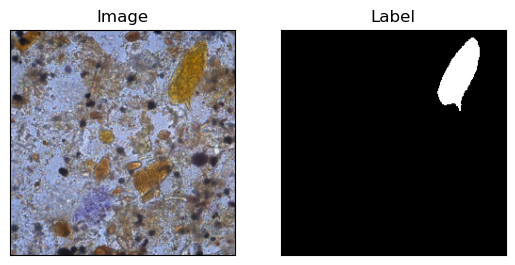

In [4]:
images = os.listdir(ORIG_PATH)
images.sort()
labels = images # Label images have the same filename of the originals

# 80% of train and 20% of test
n_train = int((0.8 * len(images)))

# Train Data (File Names)
train_images = images[:n_train]
train_labels = images[:n_train]
# Test Data (File Names)
test_images = images[n_train:]
test_labels = images[n_train:]

# Image idx to visualize
idx = 0
plot_image_with_label(train_images[idx], train_labels[idx])

## 2. Configure a dataset

Now, we need to define the Dataset class. It must:

- Enable training and testing with a single image (If we want to train with a single image - Overfit). In this case, we set the parameter `image_id` to a number (e.g., 0);
- Enable training and testing using the data splits. In this case, we set the parameter `image_id` to `None`.

We start by importing the necessary libraries.

In [5]:
# First we import the necessary libraries to 
from torch.utils.data import Dataset
from typing import List, Union
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import numpy as np
from torch.utils.data import DataLoader
from PIL import ImageOps

Then, we define our dataset class:

In [6]:
class SegDataset(Dataset):
    def __init__(
        self,
        images_path: PosixPath, # Path to images
        labels_path: PosixPath, # Path to labels
        images: List[str], # List of images
        labels: List[str], # List of labels
        image_id: int = None # Image ID if training with a single image
    ):
        self.images_path = [images_path / Path(image) for image in images]
        self.labels_path = [labels_path / Path(label) for label in labels]
        self.image_id = image_id

        """Transform input images to normalized tensors.
        [0, 255] -> [0, 1]
        """
        self.image_transforms = transforms.ToTensor()
        self.label_transforms = transforms.ToTensor()

    def __len__(self):
        # If image id not provided, we are training with all data
        if self.image_id == None:
            return len(self.images_path)
        else:
            return 1

    def __getitem__(self, idx):
        if self.image_id == None:
            image_path = self.images_path[idx]
            label_path = self.labels_path[idx]
        else:
            image_path = self.images_path[self.image_id]
            label_path = self.labels_path[self.image_id]

        image = self.image_transforms(Image.open(image_path))
        label = ImageOps.grayscale(Image.open(label_path))
        label = self.label_transforms(label)
        
        # Redefine the label image to have two prediction channels: 
        # the Background and Foreground channels.
        background = torch.zeros(1, label.shape[1], label.shape[2])
        foreground = torch.zeros(1, label.shape[1], label.shape[2])
        background[label == 0] = 1
        foreground[label == 1] = 1
        label = torch.cat([background, foreground], axis=0)

        return image, label

Now, let us visualize the output of our dataset object for a single image. The method `visualize_dataset_item` enables us to visualize an image of our dataset.

Notice that it generates two masks, one for our foreground (parasite egg) and the other for the background.

In [7]:
def visualize_dataset_item(dataset, item):
    img, label = dataset.__getitem__(item)
    viz_array = np.zeros(shape=(img.shape[1], img.shape[2], img.shape[0]))
    viz_array[:, :, 0] = img[0, :, :]
    viz_array[:, :, 1] = img[1, :, :]
    viz_array[:, :, 2] = img[2, :, :]
    
    print("Foreground shape => ", img.shape)
    print("label shape => ", label.shape)
        
    plt.subplot(131)
    plt.yticks([]),plt.xticks([])
    plt.title("Image")
    plt.imshow(viz_array)
    plt.subplot(132)
    plt.yticks([]),plt.xticks([])
    plt.title("Background")
    plt.imshow(label[0], cmap="gray")
    plt.subplot(133)
    plt.yticks([]),plt.xticks([])
    plt.title("Foreground")
    plt.imshow(label[1], cmap="gray")
    

Then, we define our dataset using all training and testing data.

In [8]:
# DATASETS - TRAIN AND TEST
train_dataset = SegDataset(
    images_path=ORIG_PATH,
    labels_path=LABELS_PATH,
    images=train_images,
    labels=train_labels,
    image_id=None
)
test_dataset = SegDataset(
    images_path=ORIG_PATH,
    labels_path=LABELS_PATH,
    images=test_images,
    labels=test_labels,
    image_id=None
)

Test the method `visualize_dataset_item` to visualize different images (change the `dataset` and `item` parameters).

Foreground shape =>  torch.Size([3, 240, 240])
label shape =>  torch.Size([2, 240, 240])


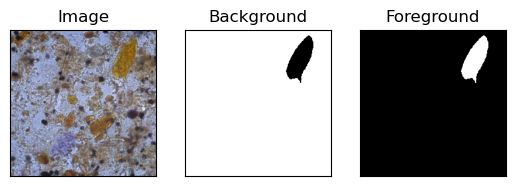

In [9]:
visualize_dataset_item(
    dataset=train_dataset,
    item=0
)

## 3. Configure our dataset as a dataloader

Finally, through PyTorch data loader ([`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)), we configure our dataset as a data loader by using:

- A Dataset (Our Train and Test datasets);
- A batch size (Number of images used to update the model's parameters);
- If we want to shuffle our data at each epoch (We see images in different orders for each epoch).

In [10]:
# DATALOADERS - TRAIN AND TEST
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Visualizes shape of a batch sampled from train dataloder
sample_train_images, sample_train_labels = next(iter(train_dataloader))
print("Images shape => ", sample_train_images.shape)
print("Labels shape => ", sample_train_labels.shape)

Images shape =>  torch.Size([4, 3, 240, 240])
Labels shape =>  torch.Size([4, 2, 240, 240])


## 4. Define a fully convolutional network (U-Net);

Now, we have a dataloader working. It is responsible for feeding data, both the input image and the parasite egg's segmentation mask, to a deep learning model. We expect that, given an input image, our model will learn to segment the parasite egg, if any.

Now, the following cells define our deep-learning model, a U-Net architecture (**see the image below**). We also enable our model to store the activation maps for visual analysis.

U-Net architectures have two parts: an encoder (left part) and a decoder (right part). The encoder extracts image features at different levels while the encoder combines those extracted features to detect and segment.

![](arch_sample.png)

First, we import necessary libraries.

In [11]:
import torch
from torch import nn
from tifffile import imsave
import torch_snippets

Let us first define some methods to help us:

- **up_conv:** Implements our **ConvTranspose2d** convolutions, responsible for upsampling our features in the decoder;
- **Conv:** Implements our **Conv2D** in decoders;
- **init_weights:** Initializes our model's parameters, using Xavier uniform for convolution's weights and setting biases to 0.01.

In [12]:
# Upsamples input feature map
def up_conv(in_channels, out_channels, kernel_size=2, padding=0, stride=2, output_padding=0):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, output_padding=output_padding),
        nn.ReLU(inplace=True)
    )
    
# Defines convolutional blocks for our decoder
def conv(in_channels, out_channels, kernel_size, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    
# Initializes kernel weights
def init_weights(m):
    if (isinstance(m,nn.Conv2d) or (isinstance(m,nn.ConvTranspose2d))):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

Now, the class UNet defines our U-Net architecture:

1. On the **__init__** method, we first set a random_seed to guarantee reproducibility. Then, we define our encoder blocks (block1, block2, and block3), our bottleneck, and finally, our decoder (up_convs + dec_convs and the pred convolution, which outputs our segmentation mask);
2. Our **forward** method is responsible for passing the input image through the model architecture until we get the parasite egg's mask at the end;
3. **write_activation** and **save_activations** saves activations of each network block for visual inspection;
4. **save_curves** will save the learning curves of our models at the end of our training loop.

To initialize a U-Net model, we must set the following parameters:

- `in_channels:` The number of channels of our input (e.g., 3 for RGB and 1 for Gray);
- `n_kernels:` A list of 3 integer values specifying the number of kernels for each convolutional block (e.g., [8, 16,32]). Those values are used to define both encoder and decoder convolutional blocks;
- `kernel_sizes:` A list of 3 integer values, specifying the kernels' size for each convolutional block (e.g., [3, 3, 3]);
- `activations_path:` A path to save each convolutional block activation. After training, one could navigate into that folder to visualize what kind of features the model is extracting.

In [13]:
class UNet(nn.Module):
    def __init__(
            self, in_channels: int, # RGB or LAB -> 3 Channels
            n_kernels: List[int], # N Kernels by conv block
            kernel_sizes: List[int], # Kernel sizes by conv block
            bottleneck_size: int, # Kernel size for bottleneck
            activations_path: PosixPath = None # Path to save activations
    ) -> None:
        super().__init__()
        
        # Sets torch seed to guaratee Reproducibility
        random_seed = 7
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        self.activations_path = activations_path
        
        # Encoder Convolutional Blocks
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=n_kernels[0],
                kernel_size=kernel_sizes[0],
                padding=kernel_sizes[0] // 2
            ),
            nn.BatchNorm2d(n_kernels[0]),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3, stride=2,
                padding=1
            )
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_kernels[0], out_channels=n_kernels[1],
                kernel_size=kernel_sizes[1],
                padding=kernel_sizes[1] // 2
            ),
            nn.BatchNorm2d(n_kernels[1]),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3, stride=2,
                padding=1
            )
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_kernels[1], out_channels=n_kernels[2],
                kernel_size=kernel_sizes[2],
                padding=kernel_sizes[2] // 2
            ),
            nn.BatchNorm2d(n_kernels[2]),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3, stride=2,
                padding=1
            )
        )
        
        # Bottleneck
        self.bottleneck = nn.Conv2d(
            in_channels=n_kernels[2], out_channels=2*n_kernels[2],
            kernel_size=bottleneck_size, stride=2, padding=bottleneck_size//2
        )
        
        # Decoder
        self.up_conv1 = up_conv(
            in_channels=2*n_kernels[2], out_channels=n_kernels[2]
        )
        self.dec_conv1 = conv(
            in_channels=2*n_kernels[2], out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2], padding=kernel_sizes[2] // 2
        )
        self.up_conv2 = up_conv(
            in_channels=n_kernels[2], out_channels=n_kernels[1]
        )
        self.dec_conv2 = conv(
            in_channels=2*n_kernels[1], out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1], padding=kernel_sizes[1] // 2
        )
        self.up_conv3 = up_conv(
            in_channels=n_kernels[1], out_channels=n_kernels[0]
        )
        self.dec_conv3 = conv(
            in_channels=2*n_kernels[0], out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0], padding=kernel_sizes[0] // 2
        )
        self.up_conv_pred = up_conv(
            in_channels=n_kernels[0], out_channels=n_kernels[0]
        )
        self.pred = nn.Conv2d(
            in_channels=n_kernels[0], out_channels=2, kernel_size=1
        )
        
        # Initializes weights
        self.block1.apply(init_weights)
        self.block2.apply(init_weights)
        self.block3.apply(init_weights)
        self.up_conv1.apply(init_weights)
        self.dec_conv1.apply(init_weights)
        self.up_conv2.apply(init_weights)
        self.dec_conv2.apply(init_weights)
        self.up_conv3.apply(init_weights)
        self.dec_conv3.apply(init_weights)
        self.up_conv_pred.apply(init_weights)
        self.pred.apply(init_weights)    
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Dictionary to keep track of activations
        self.activations = {"encoder": [], "decoder": []}
              
        # Encoder
        x1 = self.block1(x)
        self.activations["encoder"].append(x1)
        x2 = self.block2(x1)
        self.activations["encoder"].append(x2)
        x3 = self.block3(x2)
        self.activations["encoder"].append(x3)
        
        # Bottleneck
        bottleneck = self.bottleneck(x3)
        
        # Decoder - torch.cat performs skip connections on decoder
        x = self.up_conv1(bottleneck)
        x = torch.cat([x, x3], dim=1)
        x = self.dec_conv1(x)
        self.activations["decoder"].append(x)
        x = self.up_conv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec_conv2(x)
        self.activations["decoder"].append(x)
        x = self.up_conv3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec_conv3(x)
        self.activations["decoder"].append(x)
        x = self.up_conv_pred(x)
        x = self.pred(x)
        
        return x
    
    def write_activation(
        self, image: np.ndarray, path: PosixPath, reshape: bool=False
    ) -> None:
        max_img = np.max(image)
        min_img = np.min(image)
        if (min_img != max_img):
            image = 255 * (image - min_img) / (max_img - min_img)
        image = image.astype(np.uint8)

        image = Image.fromarray(image)
        if reshape:
            image = image.resize((240, 240), Image.Resampling.NEAREST)
        image.save(path)
    
    @torch.no_grad()
    def save_activations(self, epoch: int, data_loader) -> None:
        # Save encoder activations
        activations_path = self.activations_path / Path(f"epoch_{epoch}")
        
        # Save activations for each image
        print("[INFO] Saving activations!")
        images_path = data_loader.dataset.images_path
        for image_path in tqdm(images_path):
            image_name = os.path.basename(image_path)
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("encoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("encoder_reshape") 
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            
            image_data = data_loader.dataset.image_transforms(Image.open(image_path))
            # Adds batch dimension
            image_data = torch.unsqueeze(image_data, dim=0)
            image_data = image_data.to(DEVICE)
            self.to(DEVICE)
            self.forward(image_data)
        
            # Save encoder activations
            for actv_idx, activations in enumerate(self.activations["encoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size image
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                )
                    
            # Save decoder activations
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("decoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("decoder_reshape") 
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            for actv_idx, activations in enumerate(self.activations["decoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size imagace
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                    )

        # Save model weights
        torch.save(self.state_dict(), activations_path / Path("model.pth"))
        
    def save_curves(self, logger: torch_snippets.torch_loader.Report) -> None:
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(['trn_loss'], ax=ax)
        savefig_path = self.activations_path / Path("loss.png")
        plt.savefig(savefig_path)
        
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(['trn_accuracy'], ax=ax)
        savefig_path = self.activations_path / Path("accuracy.png")
        plt.savefig(savefig_path)

## 5. Define a training loop

We have everything prepared in our pipeline; we lack a training loop, which will feed data from the data loader to our model, and use the model's prediction to compute loss and update the model's parameter.

First, we import the necessary libraries.

In [14]:
from torch_snippets import optim, Report
from torchsummary import summary
import monai
from monai.losses import DiceLoss
import cv2

Secondly, we define a loss function which we want to optimize. Those loss functions were calculated by comparing the model's prediction with the ground-truth segmentation mask. To optimize those loss functions is to produce better segmentation masks.

Below, we made avaialable the following losses:

- [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)
- [BCE](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss)
- [DiceLoss](https://docs.monai.io/en/stable/losses.html)

> See our slide decks and the link provided for further details.

In [15]:
loss_fuctions = {
    "mse": nn.MSELoss(),
    "bce": nn.BCELoss(),
    "dice": DiceLoss(sigmoid=False, batch=False),
}

Now, we define our loss class. It is responsible for computing the loss for both masks (background and foreground), but it also enables us to set different weights for each mask.

To configure it, we must:

- Provide a loss function from the dictionary above (`loss_fn parameter`);
- Set the `weights` parameters as a list with weights for each class.

In [16]:
# Define loss class, to compute losses using weights
class Loss(nn.Module):
    def __init__(
            self,
            loss_fn,
            weights: List[float] = [1.0, 1.0]
        ):
        super().__init__()
        self.loss_fn = loss_fn
        self.background_weight = weights[0]
        self.foreground_weight = weights[1]

    def forward(self, y_pred, y_true):
        background_loss = self.loss_fn(y_pred[:,0, ...], y_true[:, 0, ...])
        foreground_loss = self.loss_fn(y_pred[:,1, ...], y_true[:, 1, ...])
        background_loss *= self.background_weight
        foreground_loss *= self.foreground_weight
        loss = background_loss + foreground_loss
        return loss

Finally, we define our training loop. For such, we must provide:

- The number of epochs to train our model;
- Our U-Net model;
- A data loader;
- The name of our loss_function (e.g., "mse", "bce");
- Our learning rate (lr), which controls the size of updates in the models' parameters. A too-high value will cause instability, while a too-low value will result in slower training;
- A list with weights for background and foreground (e.g., [1, 1]).

> The N_SAVE_ACTIVATIONS variable controls when we save our convolution activations. For instance, currently, it writes activations for every 200 epochs.

In [40]:
N_SAVE_ACTIVATIONS = 200
def train_loop(epochs, model, dataloader, lr, loss_function, weights):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(DEVICE)
    logger = Report(epochs)
    loss = Loss(loss_function, weights)

    for epoch in range(epochs):
        losses = []
        accuracies = []
        for batch in dataloader: # In our case, a single image, or 3
            model.train()
            image, ground_truth = batch
            image = image.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)
            prediction = model(image)
            optimizer.zero_grad()

            # Computes loss and accuracy
            prediction = torch.sigmoid(prediction)
            loss_value = loss(prediction, ground_truth)

            accuracy = (
                (prediction[:,1,...] > prediction[:,0,...]) == ground_truth[:,1,...]
            ).float().mean()
            losses.append(loss_value)
            accuracies.append(accuracy)

            loss_value.backward()
            optimizer.step()
        
        mean_loss = torch.mean(torch.Tensor(losses))
        mean_acc = torch.mean(torch.Tensor(accuracies))
        logger.record(
            epoch + 1,
            trn_loss=mean_loss.item(),
            trn_accuracy=mean_acc.item()
            )
        if ((epoch + 1) % N_SAVE_ACTIVATIONS) == 0:
            model.save_activations(epoch, dataloader)

    model.save_curves(logger)

## 6. Define a testing loop

First, we import necessary libraries

In [41]:
from medpy.metric import binary
from torchmetrics import JaccardIndex
np.bool = np.bool_

The cells below define a method to use our trained model and predict a segmentation map. We also compute metrics between the prediction map and the ground truth. The following metrics were used:

- [Accuracy](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html);
- [Dice](http://loli.github.io/medpy/generated/medpy.metric.binary.dc.html#medpy.metric.binary.dc);
- [Intersection-over-Union](https://torchmetrics.readthedocs.io/en/stable/classification/jaccard_index.html), also know as jaccard_index.

> It will also save the predictions to the folder where activations of our model are saved.

In [42]:
# This code gets the trained model and execute inferences on the Dataloader
@torch.no_grad()
def predict_and_evaluate(
        model: UNet, 
        data_loader:torch.utils.data.dataloader.DataLoader
    ):
    images_path = data_loader.dataset.images_path
    labels_path = data_loader.dataset.labels_path
    folder_to_save = model.activations_path / Path("0_preds")
    os.makedirs(folder_to_save, exist_ok=True)
    
    accuracies = []
    dices = []
    ious = []
    jaccard_index = JaccardIndex(num_classes=2, task="binary")

    for image_path, label_path in tqdm(zip(images_path, labels_path)):
        image_data = data_loader.dataset.image_transforms(Image.open(image_path))
        ground_truth = data_loader.dataset.label_transforms(
            ImageOps.grayscale(Image.open(label_path))
        )
        ground_truth = ground_truth.cpu().detach().numpy()[0]
        # Adds batch dimension
        image_data = torch.unsqueeze(image_data, dim=0)
        image_data = image_data.to(DEVICE)
        prediction = model(image_data)
        prediction = torch.sigmoid(prediction)
        
        image_name = os.path.basename(image_path)
        path_to_save = folder_to_save / Path(image_name)
        mask = np.zeros((240, 240), dtype=np.uint8)
        prediction = prediction.cpu().detach().numpy()
        mask[(prediction[0,1,...] > prediction[0,0,...])] = 1
        
        accuracy = np.mean((mask == ground_truth).astype(np.float32))
        accuracies.append(accuracy)
        # Verifies if there is parasite eggs on images
        if np.any(ground_truth > 0):
            dice = binary.dc(mask, ground_truth)
            dices.append(dice)
            iou = jaccard_index(torch.Tensor(mask).long(), torch.Tensor(ground_truth).long())
            
            ious.append((iou.numpy()))
        else: # If not
            # If there is no parasite and our model predicted it, dice and iou equals 0
            if np.any(mask > 0):
                dices.append(0)
                ious.append(0)
            # If there is no parasite and our model do not predicted it, dice and iou equals 1 (100%)
            else:
                dices.append(1)
                ious.append(1)
                
        
        cv2.imwrite(
            str(path_to_save), mask * 255
        )
    
    accuracies = np.array(accuracies)
    dices = np.array(dices)
    ious = np.array(ious)
    
    print(f"[INFO] Avg Accuracy: {np.mean(accuracies)} +/- {np.std(accuracies)}")
    print(f"[INFO] Avg Dice: {np.mean(dices)} +/- {np.std(dices)}")
    print(f"[INFO] Avg IoU: {np.mean(ious)} +/- {np.std(ious)}")

## 7. Run a training experiment and test our model.

In [43]:
# Defines model to train
kernel_size = 7
unet = UNet(
    in_channels=3,
    n_kernels=[16, 32, 64],
    kernel_sizes=[kernel_size, kernel_size, kernel_size],
    bottleneck_size=kernel_size,
    activations_path=DATA_PATH / Path("exper/ksize_{}_full_data".format(kernel_size))
).to(DEVICE)

Then, we run our training loop, using the training data loader defined before:

EPOCH: 1.000  trn_loss: 1.244  trn_accuracy: 0.828  (1.95s - 387.83s remaining)
EPOCH: 2.000  trn_loss: 1.162  trn_accuracy: 0.984  (3.90s - 386.08s remaining)
EPOCH: 3.000  trn_loss: 1.101  trn_accuracy: 0.988  (5.88s - 386.42s remaining)
EPOCH: 4.000  trn_loss: 1.055  trn_accuracy: 0.988  (7.88s - 386.28s remaining)
EPOCH: 5.000  trn_loss: 1.022  trn_accuracy: 0.988  (9.91s - 386.33s remaining)
EPOCH: 6.000  trn_loss: 1.000  trn_accuracy: 0.988  (11.94s - 386.11s remaining)
EPOCH: 7.000  trn_loss: 0.984  trn_accuracy: 0.988  (13.99s - 385.59s remaining)
EPOCH: 8.000  trn_loss: 0.968  trn_accuracy: 0.988  (16.07s - 385.68s remaining)
EPOCH: 9.000  trn_loss: 0.953  trn_accuracy: 0.989  (18.27s - 387.71s remaining)
EPOCH: 10.000  trn_loss: 0.942  trn_accuracy: 0.989  (20.53s - 390.08s remaining)
EPOCH: 11.000  trn_loss: 0.934  trn_accuracy: 0.990  (22.78s - 391.45s remaining)
EPOCH: 12.000  trn_loss: 0.931  trn_accuracy: 0.988  (25.14s - 393.79s remaining)
EPOCH: 13.000  trn_loss: 0.927

100%|██████████| 301/301 [00:00<00:00, 38861.25it/s]


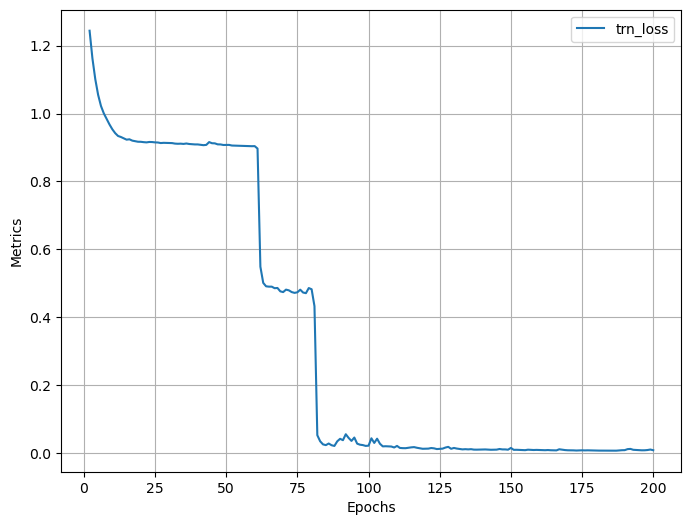

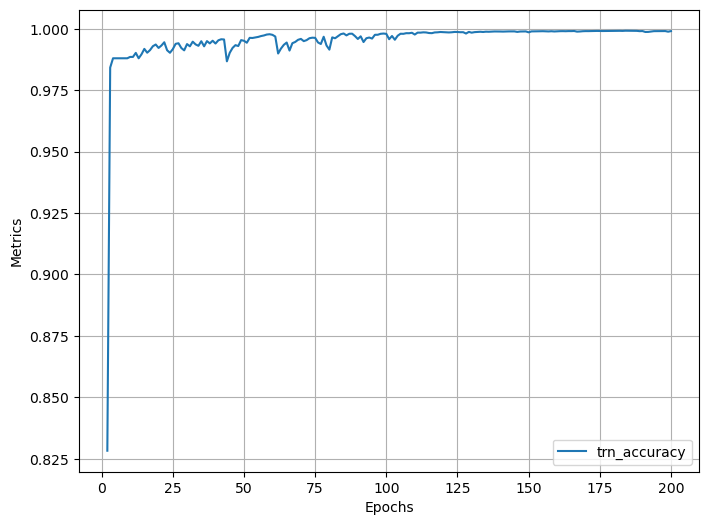

In [44]:
train_loop(
    epochs=200,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["dice"],
    weights=[1, 1] # Classes weights (Background and Foreground)
)

Finally, we run our testing method (`predict_and_evaluate`) for the trained model, using the training and testing data.

In [45]:
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)

[INFO] Training Metrics


76it [00:01, 50.99it/s]

[INFO] Avg Accuracy: 0.9990997314453125 +/- 0.0008909238968044519
[INFO] Avg Dice: 0.9533514104261257 +/- 0.15807594648301168
[INFO] Avg IoU: 0.9346413431983245 +/- 0.15858326910762044


In [46]:
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

[INFO] Test Metrics


20it [00:00, 52.45it/s]

[INFO] Avg Accuracy: 0.9925451278686523 +/- 0.008851022459566593
[INFO] Avg Dice: 0.5886403449418418 +/- 0.4480308787718541
[INFO] Avg IoU: 0.5557463964447379 +/- 0.43849437758083903


As we saw previously, Dice and IoU scores are more suitable for assessing segmentation performance. By analyzing those metrics, we see that our model performed better on training data than on testing data. This behavior suggests overfitting, where the model learns its parameters to adjust to the training data and cannot generalize well to unseen data. To solve this problem, we have some approaches. Examples are:

- We could simplify our model so it does not learn a function that over-adjusts to the training data;
- We could implement augmentations on our training data, increasing the training size. By feeding different images, we could force our model to learn more discriminative images. We will learn about augmentations in the classification notebooks.

Finally, we could visualize activations generated by our convolutional blocks. Below there is an example of activation for the image 000001.png.

![](layer_1_ch_11.png)

> Navigate to your activations folder (at ../data/parasites/exper/ksize_7_full_data/epoch_399), and visualize additional activations.

# Extra - Activities

- Experiment simplifying your model (less filters and smaller filters) an verify your results.
    - Explore different size of kernels and visualize model's activations and improvements on performance metrics
    - Explore different number of kernels and visualize model's activation and improvements on performance metrics
- Explore different losses, and classes' weights to improve performance metrics (DICE and IoU)